In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm
from pathlib import Path
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, concatenate
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.models import Model

# Parameters

In [149]:
# input
INPUT = Path(r'D:\ML Datasets\kagglecatsanddogs_5340')
OUTPUT_MODEL = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models')
SPLIT = Path(r'D:\ML Datasets\kagglecatsanddogs_5340\Split')
IMG_WIDTH, IMG_HEIGHT = 256, 256
RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT = 128, 128

In [150]:
def plot_confusion_matrix(cm: np.ndarray,
                          target_names: list,
                          title: str='Confusion matrix',
                          cmap: str=None,
                          normalize: bool=True):
    '''given a sklearn confusion matrix (cm), make a nice plot

    Args:
        cm:           confusion matrix from sklearn.metrics.confusion_matrix

        target_names: given classification classes such as [0, 1, 2]
                      the class names, for example: ['high', 'medium', 'low']

        title:        the text to display at the top of the matrix

        cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                      see http://matplotlib.org/examples/color/colormaps_reference.html
                      plt.get_cmap('jet') or plt.cm.Blues

        normalize:    If False, plot the raw numbers
                      If True, plot the proportions
    '''

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [177]:
def dataset(test_dataset, folder):
    cats = glob(
        str(
            Path(
                test_dataset,
                folder,
                'Cat',
                '*.jpg'
            )
        )
    )

    dogs = glob(
        str(
            Path(
                test_dataset,
                folder,
                'Dog',
                '*.jpg'
            )
        )
    )

    dataset = pd.concat(
        [
            pd.DataFrame(
                {
                    'path':cats,
                    'class':[1]*len(cats),
                    'file_name': [path[ len( str(Path(test_dataset,folder,'Cat')))+1:] for path in cats]
                }
            ),
            pd.DataFrame(
                {
                    'path':dogs,
                    'class':[0]*len(dogs),
                    'file_name': [path[ len( str(Path(test_dataset,folder,'Dog')))+1:] for path in dogs]
                }
            )
        ]
    )

    dataset.sort_values(by=['class','file_name'], inplace=True)

    # list
    X_test = []
    y_test = []

    for idx, row in dataset.iterrows():
        img = Image.open(row['path'])
        img = img.resize((RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT))
        img = np.array(img)
        img = img * (1/255)
        if folder == 'Depth Map':
            img = np.expand_dims(img, -1)
        elif folder == 'Color':
            #img = np.expand_dims(img, 3)
            pass

        X_test.append(img)
        y_test.append(row['class'])


    X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_test = np.expand_dims(y_test, -1)

    return X_test,  y_test



In [185]:
def evaluation(model_path, model_name, test_dataset):
    # load json and create model
    json_file = open(str(Path(model_path , f'{model_name}.json')), 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(str(Path(model_path, f'{model_name}.h5')))
    print("Loaded model from disk") 

    ####################### Datasets

    X_test_color, y_test_color = dataset(test_dataset, folder='Color')
    X_test_depth, y_test_depth = dataset(test_dataset, folder='Edited')
   

    ################################################# Predictions
    with tf.device('/device:GPU:0'):
     y_predictions = model.predict(x=[X_test_color, X_test_depth])

    THRESHOLD = 0.5
    y_predict_class = []
  
    for prob in y_predictions:

        clase = np.argmax(prob)
        if clase == 1:
            y_predict_class.append(1)
        elif clase == 0:
            y_predict_class.append(0)
    
    confusion_matrix(
            y_true = y_test_color.reshape(-1), 
            y_pred = y_predict_class
        )

    tn, fp, fn, tp = confusion_matrix(
        y_true = y_test_color.reshape(-1), 
        y_pred = y_predict_class).ravel()
    
    recall_cats    = tp / (tp + fn)
    precision_cats = tp / (tp + fp)
    fscore_cats =  (2*recall_cats*precision_cats) /  (recall_cats + precision_cats)

    recall_dogs    = tn / (fp + tn)
    precision_dogs = tn / (tn + fn)
    fscore_dogs =  (2*recall_dogs*precision_dogs) /  (recall_dogs + precision_dogs)

    accuracy = (tp + tn) / sum([tn, fp, fn, tp])

    plot_confusion_matrix(
        cm = confusion_matrix(
            y_true = y_test_color.reshape(-1), 
            y_pred = y_predict_class), 
        target_names=['0','1'],
        normalize=False,
        title='Matriz de Confusión: Clase Cat (1) & Clase Dog (0)',
        cmap=plt.cm.Blues
        )
    
    print(f'Recall Cat {recall_cats:,.2f}')
    print(f'Precision Cat {precision_cats:,.2f}')
    print(f'Fscore Cat {fscore_cats:,.2f}')
    print('--------------------------------')
    print(f'Recall Dog {recall_dogs:,.2f}')
    print(f'Precision Dog {precision_dogs:,.2f}')
    print(f'Fscore Dog {fscore_dogs:,.2f}')
    print('--------------------------------')
    print(f'Accuracy {accuracy:,.2f}')

# Dataset

In [153]:
# create a data generator
datagenTrain_color = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=25,
    horizontal_flip=True,
    # vertical_flip=True,
    zoom_range=[0.9, 1.2],
    brightness_range =[0.7,1.3],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
    )
datagenTest_color = ImageDataGenerator(rescale = 1./255)
datagenVal_color = ImageDataGenerator(rescale = 1./255)


# create a data generator
datagenTrain_depth = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    # vertical_flip=True,
    zoom_range=[0.9, 1.2],
    brightness_range =[0.7,1.3],
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
    )
datagenTest_depth = ImageDataGenerator(rescale = 1./255)
datagenVal_depth = ImageDataGenerator(rescale = 1./255)

In [154]:
ImageGeneratorSeed = 12345

In [155]:
BATCH = 32

# Color datagen

In [156]:
DIM = 'Color'
color_mode='rgb'
color_dim = 3

print(color_mode)
print(DIM)

#loading data
train_generator_color = datagenTrain_color.flow_from_directory(
    directory = str(Path(SPLIT,'Train',DIM)),
    classes=['Dog','Cat'],
    class_mode='categorical',
    batch_size=BATCH,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode,
    shuffle=False,
    seed=ImageGeneratorSeed
)

test_generator_color = datagenTest_color.flow_from_directory(
    directory = str(Path(SPLIT,'Test',DIM)),
    classes=['Dog','Cat'],
    class_mode='categorical',
    batch_size=BATCH,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode,
    shuffle=False,
    seed=ImageGeneratorSeed
)

val_generator_color = datagenVal_color.flow_from_directory(
    directory = str(Path(SPLIT,'Val',DIM)),
    classes=['Dog','Cat'],
    class_mode='categorical',
    batch_size=BATCH,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode,
    shuffle=False,
    seed=ImageGeneratorSeed
)

rgb
Color
Found 17498 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.
Found 5250 images belonging to 2 classes.


# Depth datagen

In [157]:
DIM = 'Edited'
color_mode='rgb'
color_dim = 3


print(color_mode)
print(DIM)

#loading data
train_generator_depth = datagenTrain_depth.flow_from_directory(
    directory = str(Path(SPLIT,'Train',DIM)),
    classes=['Dog','Cat'],
    class_mode='categorical',
    batch_size=BATCH,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode,
    shuffle=False,
    seed=ImageGeneratorSeed
)

test_generator_depth = datagenTest_depth.flow_from_directory(
    directory = str(Path(SPLIT,'Test',DIM)),
    classes=['Dog','Cat'],
    class_mode='categorical',
    batch_size=BATCH,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode,
    shuffle=False,
    seed=ImageGeneratorSeed
)

val_generator_depth = datagenVal_depth.flow_from_directory(
    directory = str(Path(SPLIT,'Val',DIM)),
    classes=['Dog','Cat'],
    class_mode='categorical',
    batch_size=BATCH,
    target_size=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT),
    color_mode=color_mode,
    shuffle=False,
    seed=ImageGeneratorSeed
)

rgb
Edited
Found 17498 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.
Found 5250 images belonging to 2 classes.


In [158]:
class DualInputGenerator:
    def __init__(self, generator1, generator2):
        self.generator1 = generator1
        self.generator2 = generator2

    def __len__(self):
        return min(len(self.generator1), len(self.generator2))

    def __iter__(self):
        return self

    def __next__(self):
        X1, y1 = next(self.generator1)
        X2, y2 = next(self.generator2)
        
        # Ensure the labels are the same
        assert np.array_equal(y1, y2), "Labels do not match in the generators"
        return [X1, X2], y1




train_generator = DualInputGenerator(train_generator_color, train_generator_depth)
val_generator = DualInputGenerator(val_generator_color, val_generator_depth)


In [159]:
test_generator = DualInputGenerator(test_generator_color, test_generator_depth)

# GPU Configs

In [160]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [161]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*10)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## CNN

In [162]:
model_path = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models')
model_name = 'Model_Color_128_128'

# load json and create model
json_file = open(str(Path(model_path , f'{model_name}.json')), 'r')
loaded_model_json = json_file.read()
json_file.close()

model_color = model_from_json(loaded_model_json)
# load weights into new model
model_color.load_weights(str(Path(model_path, f'{model_name}.h5')))
print("Loaded model from disk") 

Loaded model from disk


In [163]:
model_path = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models')
model_name = 'Model_Edited_128_128'

# load json and create model
json_file = open(str(Path(model_path , f'{model_name}.json')), 'r')
loaded_model_json = json_file.read()
json_file.close()

model_depth = model_from_json(loaded_model_json)
# load weights into new model
model_depth.load_weights(str(Path(model_path, f'{model_name}.h5')))
print("Loaded model from disk") 

Loaded model from disk


# Fine-Tuning

In [164]:
# for layer in model_depth.layers:
#     print(layer.name)

In [165]:
# color_layers = [
#     # 'dense_45',
#     # 'dropout_115',
#     # 'dense_46',
#     # 'batch_normalization_100',
#     # 'dropout_116',
#     'dense_47'
# ]

In [166]:
# depth_layers = [
#     # 'dense',
#     # 'dropout_6',
#     # 'dense_1',
#     # 'batch_normalization_6',
#     # 'dropout_7',
#     'dense_2'
# ]

# Multi Input model

In [167]:
initializer = keras.initializers.GlorotUniform(seed=123456)

In [168]:
# -len(color_layers)

In [169]:
# model_color.pop()

In [170]:
# set false
model_depth.trainable = False
model_color.trainable = False

# Crear la red multinput
input_color = tf.keras.Input(shape=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT,3,))
input_depth = tf.keras.Input(shape=(RESCALE_IMG_WIDTH, RESCALE_IMG_HEIGHT,3,))

# Get the output of the seventh layer for each model
# color_output = model_color.layers[-len(color_layers)].output  # Adjust the index if needed
# depth_output = model_depth.layers[-len(depth_layers)].output  # Adjust the index if needed

model_color.pop()
model_depth.pop()

# Get the output of the seventh layer for each model
color_output = model_color.output  # Adjust the index if needed
depth_output = model_depth.output  # Adjust the index if needed

# Create new models with the desired output
color_model = Model(inputs=model_color.input, outputs=color_output)
depth_model = Model(inputs=model_depth.input, outputs=depth_output)

# Now, use color_model and depth_model to get the outputs of the seventh layer
color_features = color_model(input_color)
depth_features = depth_model(input_depth)

# Combine the features
combined = concatenate([color_features, depth_features])



# output = Dense(128, activation="relu", kernel_initializer=initializer)(combined)
# output = BatchNormalization()(output)
# output = Dropout(0.25)(output)
# output = Dense(64, activation="relu", kernel_initializer=initializer)(output)
# output = BatchNormalization()(output)
# output = Dropout(0.25)(output)
output = Dense(2, activation="softmax", kernel_initializer=initializer)(combined)


# model
multi_input_model = tf.keras.Model(inputs=[input_color, input_depth], outputs=output, name='Dogs_Cats_Multi_input')
display(multi_input_model.summary())


Model: "Dogs_Cats_Multi_input"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_12 (Functional)          (None, 128)          699008      ['input_13[0][0]']               
                                                                              

None

In [171]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

multi_input_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics='accuracy'
    )

# reduce_lr = tf.keras.callbacks.LearningRateScheduler(
#     lambda x: 0.001*0.9**x
# )


reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15
)

In [172]:
# Assuming you know the total number of samples and batch size
train_samples = train_generator_depth.samples  # Total number of training samples
val_samples = val_generator_depth.samples      # Total number of validation samples
batch_size = BATCH          # Batch size used in the generators

steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size


print('steps_per_epoch  ',steps_per_epoch )
print('validation_steps ',validation_steps)

steps_per_epoch   546
validation_steps  164


In [173]:
with tf.device('/device:GPU:0'):
    history = multi_input_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=100,
        callbacks=[reduce_lr_on_plateau, early_stop],
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )


Epoch 1/100
546/546 [==============================] - 149s 270ms/step - loss: 0.1236 - accuracy: 0.9500 - val_loss: 0.2065 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 2/100
546/546 [==============================] - 127s 232ms/step - loss: 0.0691 - accuracy: 0.9749 - val_loss: 0.2366 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 3/100
546/546 [==============================] - 126s 231ms/step - loss: 0.0588 - accuracy: 0.9790 - val_loss: 0.2753 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 4/100
546/546 [==============================] - 125s 230ms/step - loss: 0.0609 - accuracy: 0.9803 - val_loss: 0.3047 - val_accuracy: 0.9070 - lr: 0.0010
Epoch 5/100
546/546 [==============================] - 126s 232ms/step - loss: 0.0561 - accuracy: 0.9812 - val_loss: 0.3268 - val_accuracy: 0.9042 - lr: 0.0010
Epoch 6/100
546/546 [==============================] - 126s 232ms/step - loss: 0.0562 - accuracy: 0.9810 - val_loss: 0.3401 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 7/100
546/546 [===================

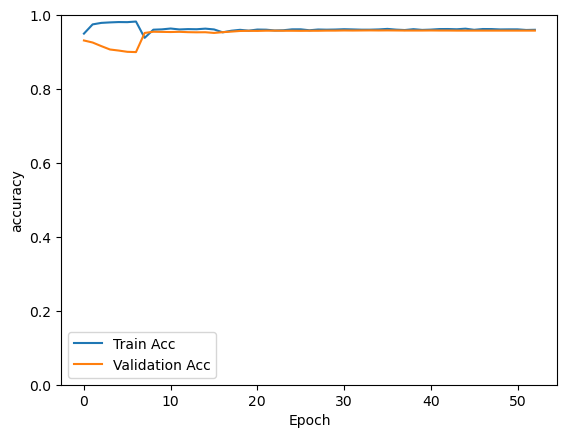

In [174]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Acc')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Validation Acc')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

plot_history(history)

# Save Model

In [175]:
model_json = multi_input_model.to_json()
with open(str(Path(OUTPUT_MODEL, f'Model_Multi_input.json')), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
multi_input_model.save_weights(str(Path(OUTPUT_MODEL, f"Model_Multi_input.h5")))
print("Saved model to disk")

Saved model to disk


# Model Evaluate

Loaded model from disk
71/71 [==============================] - 1s 11ms/step


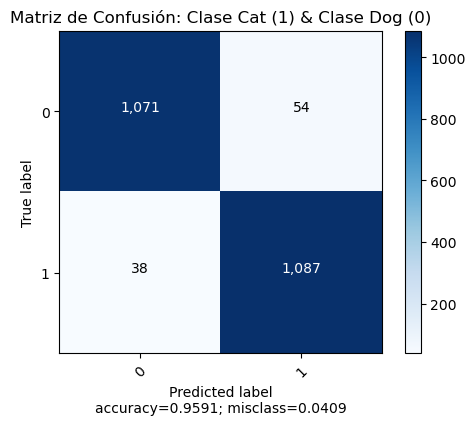

Recall Cat 0.97
Precision Cat 0.95
Fscore Cat 0.96
--------------------------------
Recall Dog 0.95
Precision Dog 0.97
Fscore Dog 0.96
--------------------------------
Accuracy 0.96


In [186]:
evaluation(
    model_path = Path(r'C:\Users\jean-\OneDrive\Documentos\DSProject\Cats And Dogs Classifier\Models'), 
    model_name = 'Model_Multi_input', 
    test_dataset = Path(r'D:\ML Datasets\kagglecatsanddogs_5340\Split\Test')
)